# Домашнее задание №1

Работаем с данными о прямых маркетинговых акциях, проводимых португальским банком. Для маркетинга использовались телефонные звонки. С одним клиентом иногда приходилось связываться несколько раз, чтобы выяснить, согласен ли он на продукт (банковский вклад с фиксированным сроком).

Цель: обучить нейронную сеть, чтобы она делала предположение исходя из данных о клиенте о возможном подписании услуги.

## 0. Подключение библиотек

In [1]:
#pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None

## 1. Прочитать данные

In [3]:
# Получение датасета
bank_marketing = fetch_ucirepo(id=222)

# Сохранение данных в виде pandas массивов
X = bank_marketing.data.features
y = bank_marketing.data.targets

# Метаданные и информация о переменных
print(bank_marketing.metadata)
print(bank_marketing.variables)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

## 2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать.

In [4]:
# Краткая информация
print(X.shape)
print(X.columns)

print(y.shape)
print(y.columns)

print("Баланс классов:", ((y[:] == 'yes').sum()/y.shape[0]).to_string(index = False, dtype = False))

(45211, 16)
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome'],
      dtype='object')
(45211, 1)
Index(['y'], dtype='object')
Баланс классов: 0.116985


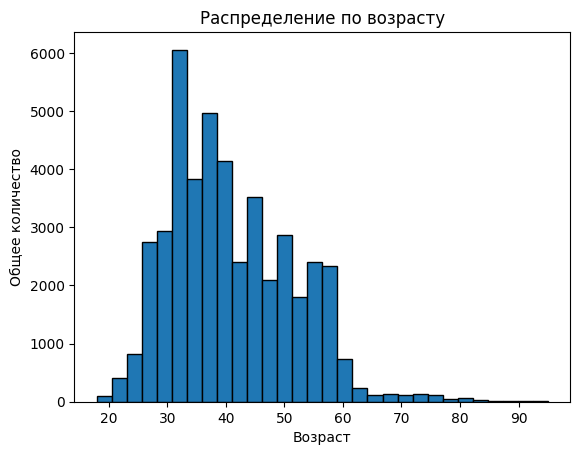

In [5]:
# Распределение по возрасту (график)
plt.hist(X['age'], bins = 30, edgecolor = 'black')
plt.xlabel('Возраст')
plt.ylabel('Общее количество')
plt.title('Распределение по возрасту')
plt.show()

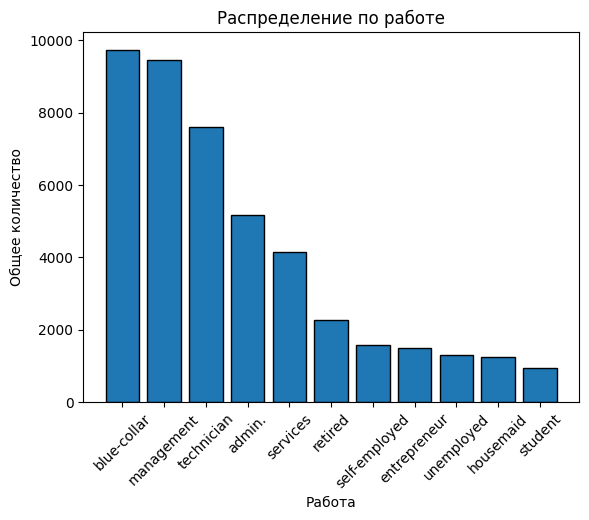

In [6]:
# Распределение по работе (график)
job_counts = X['job'].value_counts()
plt.bar(job_counts.index, job_counts.values, edgecolor = 'black')
plt.xlabel('Работа')
plt.ylabel('Общее количество')
plt.title('Распределение по работе')
plt.xticks(rotation = 45)
plt.show()

In [7]:
# Вычисление средних значений
average_values = X.mean(numeric_only = True)
print("Средние значения признаков:")
print(average_values)

Средние значения признаков:
age              40.936210
balance        1362.272058
day_of_week      15.806419
duration        258.163080
campaign          2.763841
pdays            40.197828
previous          0.580323
dtype: float64


In [8]:
# Вычисление разброса
variance_values = X.var(numeric_only = True)
print("Разброс данных (дисперсия) для числовых признаков:")
print(variance_values)

Разброс данных (дисперсия) для числовых признаков:
age            1.127581e+02
balance        9.270599e+06
day_of_week    6.926361e+01
duration       6.632057e+04
campaign       9.597733e+00
pdays          1.002577e+04
previous       5.305841e+00
dtype: float64


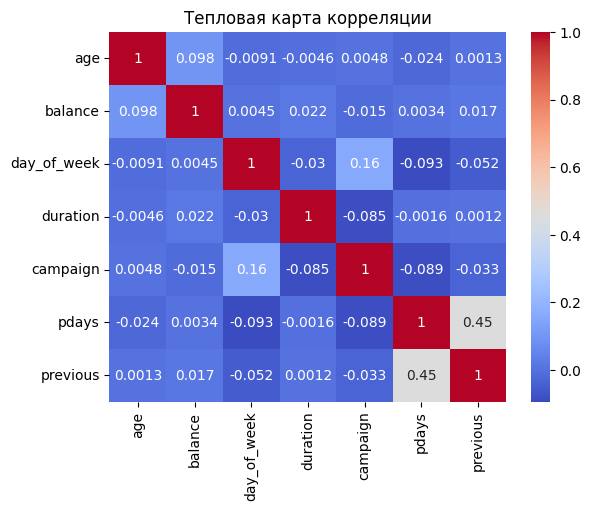

In [9]:
# Корреляционная матрица
corr_matrix = X.corr(numeric_only = True)
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm')
plt.title('Тепловая карта корреляции')
plt.show()

## 3. Обработать пропущенные значения (или убедиться, что их нет)

In [10]:
X[:].isnull().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


In [11]:
# Вспомогательная функция
def get_unique_elems(elems):
  unique = []
  for tmp in elems:
    if tmp not in unique:
      unique.append(tmp)
  return unique

In [12]:
# Выводим все уникальные значения работ
print(get_unique_elems(X['job']))

# Заменим все Null значения на empty
# Возможно люди, отказывающиеся называть своё место работы
# чаще отказывают, поэтому этот параметр нельзя опускать из обучения
X.loc[X['job'].isnull(), 'job'] = 'empty'
print(get_unique_elems(X['job']))

['management', 'technician', 'entrepreneur', 'blue-collar', nan, 'retired', 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student']
['management', 'technician', 'entrepreneur', 'blue-collar', 'empty', 'retired', 'admin.', 'services', 'self-employed', 'unemployed', 'housemaid', 'student']


In [13]:
# Выводим все уникальные значения образования
print(get_unique_elems(X['education']))

# Так как минимальный возраст оказания услуг - 18, будем
# считать, что пустые значения education как минимум 'primary'
X.loc[X['education'].isnull(), 'education'] = 'primary'
print(get_unique_elems(X['education']))

['tertiary', 'secondary', nan, 'primary']
['tertiary', 'secondary', 'primary']


In [14]:
# Выводим все уникальные значения типа связи
print(get_unique_elems(X['contact']))
print("nan: ", X['contact'].isnull().sum()/X.shape[0])

# Хоть nan занимает почти треть значений, комфорт клиента при
# разговоре может многое значить в конце сделки, поэтому
# вместо отказа от рассмотрения данного признака будем
# заполнять его признаком empty

X.loc[X['contact'].isnull(), 'contact'] = 'empty'
print(get_unique_elems(X['contact']))

[nan, 'cellular', 'telephone']
nan:  0.28798301298356593
['empty', 'cellular', 'telephone']


In [15]:
# Выводим все уникальные значения типа связи
print(get_unique_elems(X['poutcome']))

# Заменим все nan на other
X.loc[X['poutcome'].isnull(), 'poutcome'] = 'other'
print(get_unique_elems(X['poutcome']))

[nan, 'failure', 'other', 'success']
['other', 'failure', 'success']


In [16]:
# Дополнительная проверка, что все значения заполнены
X[:].isnull().sum().sum()

0

In [17]:
# Удаляем излишние данные, которые не так важны для обучения (дату звонка)
existing_columns_to_drop = [col for col in ['day_of_week', 'month'] if col in X.columns]

if existing_columns_to_drop:
    X.drop(columns=existing_columns_to_drop, inplace=True)

## 4. Обработать категориальные признаки

In [18]:
# Создаём объект LabelEncoder
label_encoder = LabelEncoder()

# Замена бинарных признаков на 0/1
binary_features = ['default', 'housing', 'loan']
for feature in binary_features:
  X[feature] = X[feature].map({'yes': 1, 'no': 0})

# Преобразуем категориальные признаки в бинарные со значениями 0/1
columns_to_encode = ['job', 'marital', 'education', 'contact', 'poutcome']
X = pd.DataFrame(X)
X = pd.get_dummies(X)

print(X)
print(X.columns)

       age  default  balance  housing  loan  duration  campaign  pdays  \
0       58        0     2143        1     0       261         1     -1   
1       44        0       29        1     0       151         1     -1   
2       33        0        2        1     1        76         1     -1   
3       47        0     1506        1     0        92         1     -1   
4       33        0        1        0     0       198         1     -1   
...    ...      ...      ...      ...   ...       ...       ...    ...   
45206   51        0      825        0     0       977         3     -1   
45207   71        0     1729        0     0       456         2     -1   
45208   72        0     5715        0     0      1127         5    184   
45209   57        0      668        0     0       508         4     -1   
45210   37        0     2971        0     0       361         2    188   

       previous  job_admin.  ...  marital_single  education_primary  \
0             0       False  ...        

In [19]:
# Приведение y к значениям 0/1
y['y'] = y['y'].map({'yes': 1, 'no': 0})
print(y)

       y
0      0
1      0
2      0
3      0
4      0
...   ..
45206  1
45207  1
45208  1
45209  0
45210  0

[45211 rows x 1 columns]


## 5. Провести нормализацию

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 6. Разбить данные на обучающую и тестовую выборки

In [21]:
# (80% - обучающая, 20% - тестовая)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 7. Классификатор K-ближайших соседей

In [22]:
n_neighbors = 3
knn_regressor = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_regressor.fit(X_train, y_train)

# Предсказание на обучающей выборке
y_train_pred = knn_regressor.predict(X_train).astype(int)
# Предсказание на тестовой выборке
y_test_pred = knn_regressor.predict(X_test).astype(int)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mean_squared_error(y_train, y_train_pred):.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mean_squared_error(y_test, y_test_pred):.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.09484
Среднеквадратичная ошибка на тестовой выборке: 0.11423
Матрица рассогласования:
 [[7875   77]
 [ 956  135]]


Вывод: риск переобучения, так как ошибка на обучающей выборке меньше, чем на тестовой. Это означает, что модель излишне адаптировалась к обучающим данным и возможно не будет хорошо работать на новых.

## 8. Подобрать оптимальное значение числа соседей

In [23]:
# Словарь n_neighbors для значений от 3 до 29
param_grid = {'n_neighbors': range(3, 30)}
grid_search = GridSearchCV(knn_regressor, param_grid)
grid_search.fit(X_train, y_train)
best_n_neighbors = grid_search.best_params_['n_neighbors']

print(f"Наилучшее число соседей: {best_n_neighbors}")

knn_best = KNeighborsRegressor(n_neighbors=best_n_neighbors)
knn_best.fit(X_train, y_train)

y_train_pred = knn_best.predict(X_train)
y_test_pred = knn_best.predict(X_test)

Наилучшее число соседей: 21


## 9. Вычислить ошибки на обучающей и тестовой выборках

In [24]:
print(f"Среднеквадратичная ошибка на обучающей выборке: {mean_squared_error(y_train, y_train_pred):.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mean_squared_error(y_test, y_test_pred):.5f}")
y_test_pred = y_test_pred.astype(int)
print("Матрица рассогласования для тестовой выборки:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.07054
Среднеквадратичная ошибка на тестовой выборке: 0.07962
Матрица рассогласования для тестовой выборки:
 [[7952    0]
 [1091    0]]


Вывод: модель не определила ни один пример из тестовой выборки как принадлежащий ко второму классу. Это говорит о том что KNN достаточно примитивный классификатор, который не справляется с несбалансированностью классов.

## 10. Запустить другие классификаторы

### Логистическая регрессия

In [25]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train.values.ravel())

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
mse_train_clf = mean_squared_error(y_train, y_train_pred)
mse_test_clf = mean_squared_error(y_test, y_test_pred)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mse_train_clf:.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mse_test_clf:.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.09907
Среднеквадратичная ошибка на тестовой выборке: 0.10085
Матрица рассогласования:
 [[7769  183]
 [ 729  362]]


###RandomForest

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train.values.ravel())

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)
mse_train_rfc = mean_squared_error(y_train, y_train_pred)
mse_test_rfc = mean_squared_error(y_test, y_test_pred)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mse_train_rfc:.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mse_test_rfc:.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.00003
Среднеквадратичная ошибка на тестовой выборке: 0.10395
Матрица рассогласования:
 [[7707  245]
 [ 695  396]]


###Вывод
Логистическая регрессия показала сбалансированный результат для решения моей задачи. При этом применение классификатора RandomForest со стандартными гиперпараметрами выдаёт минимальную ошибку на обучающей выборке, из-за которой можно сделать вывод о переобучении (хоть MSE на тестовой выборке выглядит оптимальным, стОит учесть также несбалансированность классов, из-за чего доверять такому результату всецело не получится). В связи с этим рассмотрим разные значения гиперпараметров с получаемыми при их применении ошибками для нахождения оптимальных значений.

###Разные значения гиперпараметров для RandomForest

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15]
}

rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = param_grid)
grid_search.fit(X_train, y_train.values.ravel())

best_params = grid_search.best_params_
print("Лучшие параметры: ", grid_search.best_params_)

Лучшие параметры:  {'max_depth': 15, 'n_estimators': 200}


In [28]:
rfc = RandomForestClassifier(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'])
rfc.fit(X_train, y_train.values.ravel())

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)
mse_train_rfc = mean_squared_error(y_train, y_train_pred)
mse_test_rfc = mean_squared_error(y_test, y_test_pred)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mse_train_rfc:.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mse_test_rfc:.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.04805
Среднеквадратичная ошибка на тестовой выборке: 0.10240
Матрица рассогласования:
 [[7761  191]
 [ 735  356]]


## 11. Как-то побороться с несбалансированностью классов
Буду бороться с несбалансированностью классов с применением параметра class_weight='balanced' в модели LogisticRegression.


In [29]:
clf = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
clf.fit(X_train, y_train.values.ravel())

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
mse_train_clf = mean_squared_error(y_train, y_train_pred)
mse_test_clf = mean_squared_error(y_test, y_test_pred)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mse_train_clf:.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mse_test_clf:.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.16902
Среднеквадратичная ошибка на тестовой выборке: 0.17373
Матрица рассогласования:
 [[6606 1346]
 [ 225  866]]


Как можно заметить, количество правильно определённых объектов класса 2 выросло, но при этом количество ложных срабатываний для объектов класса 1 также было увеличено, из-за чего ошибки на выборках были увеличены в обоих случаях (обучающая и тестовая выборки).

## 12. Исключение коррелированных переменных
Для возможного улучшения устойчивости и производительности модели

In [30]:
# Корреляционная матрица
corr_matrix = X.corr(numeric_only = True)
corr_matrix

,age,default,balance,housing,loan,duration,campaign,pdays,previous,job_admin.,...,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_empty,contact_telephone,poutcome_failure,poutcome_other,poutcome_success
age,1.000000,-0.017879,0.097783,-0.185513,-0.015655,-0.004648,0.004760,-0.023758,0.001288,-0.055717,...,-0.427817,0.213442,-0.093979,-0.081629,-0.068375,-0.020132,0.170349,-0.004927,-0.013912,0.035526
default,-0.017879,1.000000,-0.066745,-0.006025,0.077234,-0.010021,0.016822,-0.029979,-0.018329,-0.010037,...,0.003115,0.000853,0.013220,-0.015239,-0.010061,0.019933,-0.017208,-0.026389,0.035542,-0.023344
balance,0.097783,-0.066745,1.000000,-0.068768,-0.084350,0.021560,-0.014578,0.003435,0.016674,-0.026726,...,-0.012537,-0.008423,-0.069937,0.084001,0.015880,-0.037331,0.037999,0.011857,-0.028721,0.035240
housing,-0.185513,-0.006025,-0.068768,1.000000,0.041323,0.005075,-0.023599,0.124178,0.037076,0.043046,...,-0.020475,-0.014250,0.101659,-0.099175,-0.156071,0.208409,-0.080822,0.106795,-0.048101,-0.091360
loan,-0.015655,0.077234,-0.084350,0.041323,1.000000,-0.012412,0.009980,-0.022754,-0.011043,0.030781,...,-0.051716,-0.036431,0.070625,-0.045940,0.013604,-0.007211,-0.013183,-0.002186,0.029620,-0.053713
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,1.000000,-0.084570,-0.001565,0.001203,-0.015722,...,0.020328,-0.003671,0.002084,0.000891,0.025543,-0.014379,-0.023201,-0.018925,-0.004974,0.042389
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,-0.084570,1.000000,-0.088628,-0.032855,-0.021868,...,-0.023120,0.011614,-0.020893,0.012866,-0.032271,0.004853,0.053895,-0.088131,0.108153,-0.057486
pdays,-0.023758,-0.029979,0.003435,0.124178,-0.022754,-0.001565,-0.088628,1.000000,0.454820,0.027497,...,0.027943,-0.019273,0.022105,-0.007568,0.225996,-0.247068,0.016006,0.701052,-0.742470,0.228539
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,0.001203,-0.032855,0.454820,1.000000,0.014245,...,0.017006,-0.019345,-0.005603,0.022888,0.131717,-0.154162,0.028097,0.350627,-0.416226,0.201424
job_admin.,-0.055717,-0.010037,-0.026726,0.043046,0.030781,-0.015722,-0.021868,0.027497,0.014245,1.000000,...,0.040912,-0.108555,0.217639,-0.144780,0.000660,0.005961,-0.012291,0.018431,-0.022636,0.012056


In [31]:
# Нахождение коррелированных переменных
corr_threshold = 0.8
high_corr_pairs = [(i, j) for i in corr_matrix.columns for j in corr_matrix.columns if i != j and abs(corr_matrix.loc[i, j]) > corr_threshold]
print(high_corr_pairs)

[('contact_cellular', 'contact_empty'), ('contact_empty', 'contact_cellular'), ('poutcome_failure', 'poutcome_other'), ('poutcome_other', 'poutcome_failure')]


In [32]:
# Преобразование пар в уникальные (то есть теперь пары ('a','b') и ('b','a') будут эквивалентны)
unique_pairs = set(frozenset(pair) for pair in high_corr_pairs)
unique_pairs = [tuple(pair) for pair in unique_pairs]
print(unique_pairs)

[('contact_empty', 'contact_cellular'), ('poutcome_other', 'poutcome_failure')]


In [33]:
# Удаление коррелированных переменных
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
columns_to_drop = {pair[1] for pair in unique_pairs}
X_reduced = X_scaled_df.drop(columns=columns_to_drop)
print(X_reduced)

            age  default   balance   housing      loan  duration  campaign  \
0      1.606965 -0.13549  0.256419  0.893915 -0.436803  0.011016 -0.569351   
1      0.288529 -0.13549 -0.437895  0.893915 -0.436803 -0.416127 -0.569351   
2     -0.747384 -0.13549 -0.446762  0.893915  2.289359 -0.707361 -0.569351   
3      0.571051 -0.13549  0.047205  0.893915 -0.436803 -0.645231 -0.569351   
4     -0.747384 -0.13549 -0.447091 -1.118674 -0.436803 -0.233620 -0.569351   
...         ...      ...       ...       ...       ...       ...       ...   
45206  0.947747 -0.13549 -0.176460 -1.118674 -0.436803  2.791329  0.076230   
45207  2.831227 -0.13549  0.120447 -1.118674 -0.436803  0.768224 -0.246560   
45208  2.925401 -0.13549  1.429593 -1.118674 -0.436803  3.373797  0.721811   
45209  1.512791 -0.13549 -0.228024 -1.118674 -0.436803  0.970146  0.399020   
45210 -0.370689 -0.13549  0.528364 -1.118674 -0.436803  0.399328 -0.246560   

          pdays  previous  job_admin.  ...  marital_divorced  m

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

###Применение новых данных для обучения моделей

In [35]:
n_neighbors = 3
knn_regressor = KNeighborsRegressor(n_neighbors=n_neighbors)
knn_regressor.fit(X_train, y_train)

# Предсказание на обучающей выборке
y_train_pred = knn_regressor.predict(X_train).astype(int)
# Предсказание на тестовой выборке
y_test_pred = knn_regressor.predict(X_test).astype(int)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mean_squared_error(y_train, y_train_pred):.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mean_squared_error(y_test, y_test_pred):.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.09475
Среднеквадратичная ошибка на тестовой выборке: 0.11423
Матрица рассогласования:
 [[7876   76]
 [ 957  134]]


In [36]:
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train.values.ravel())

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
mse_train_clf = mean_squared_error(y_train, y_train_pred)
mse_test_clf = mean_squared_error(y_test, y_test_pred)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mse_train_clf:.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mse_test_clf:.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.09907
Среднеквадратичная ошибка на тестовой выборке: 0.10074
Матрица рассогласования:
 [[7769  183]
 [ 728  363]]


In [37]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train.values.ravel())

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)
mse_train_rfc = mean_squared_error(y_train, y_train_pred)
mse_test_rfc = mean_squared_error(y_test, y_test_pred)

print(f"Среднеквадратичная ошибка на обучающей выборке: {mse_train_rfc:.5f}")
print(f"Среднеквадратичная ошибка на тестовой выборке: {mse_test_rfc:.5f}")
print("Матрица рассогласования:\n", confusion_matrix(y_test, y_test_pred))

Среднеквадратичная ошибка на обучающей выборке: 0.00000
Среднеквадратичная ошибка на тестовой выборке: 0.10185
Матрица рассогласования:
 [[7725  227]
 [ 694  397]]


###Вывод
На моих данных удаление коррелированных переменных привело к незначительному улучшению работы каждой из моделей, хоть задача и решалась для несбалансированных данных. Стоит отметить, что коррелированные переменные не несут в себе идентичную информацию, из-за чего после удаления одной из них возможно убирались бы полезные признаки, которые помогали отличать редкий класс от часто встречаемого. Но этого не произошло и в итоге преобразования данных немного улучшили качество определения не только редкого, но и часто встречаемого класса для отдельных моделей.

##Общий вывод
В целом задача машинного обучения для выбранных данных показывает не очень хорошие результаты. Для корректной работы классификаторов требуется перебор большого числа параметров самих моделей. Это нужно для исключения возможного переобучения и неправильных приоритетов в пользу часто встречаемого класса.